# In-depth Model Fitting
This notebook demonstrates how error models can be fitted with the helper functions `calibr8.fit_scipy` and `calibr8.fit_pygmo`.

In [1]:
from matplotlib import pyplot, cm
import numpy
import pandas
import scipy.stats

import calibr8

## Generating fake data
For the purpose of this notebook, a synthetic dataset is sufficient.
The parameter vector of the ground truth model consists of three parts: $\theta_µ$, $\theta_\sigma$ and $theta_{df}$.

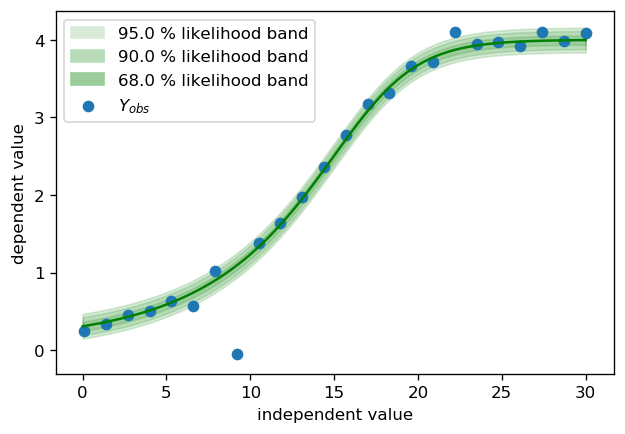

In [2]:
θ_mu = (0.1, 4, 15, 0.3, 1) # 5 parameters of the asymmetric logistic
θ_scale = (0.05,)           # 1 parameter for constant scale
θ_df = (3,)                 # 1 parameter for constant degree of freedom
# concatenate all the parameter into one vector:
θ_true = θ_mu + θ_scale + θ_df

# generate 24 calibration points with t-distributed noise
X = numpy.linspace(0.1, 30, 24)
Y = scipy.stats.t.rvs(
    loc=calibr8.asymmetric_logistic(X, θ_mu),
    scale=calibr8.polynomial(X, θ_scale),
    df=calibr8.polynomial(X, θ_df)
)

fig, ax = pyplot.subplots(dpi=120)

# plot the noise band of the ground truth
X_dense = numpy.linspace(0, 30, 100)
calibr8.plot_t_band(
    ax,
    X_dense,
    mu=calibr8.asymmetric_logistic(X_dense, θ_mu),
    scale=calibr8.polynomial(X_dense, θ_scale),
    df=calibr8.polynomial(X_dense, θ_df)
)

ax.scatter(X, Y, label='$Y_{obs}$')

ax.set_xlabel('independent value')
ax.set_ylabel('dependent value')
ax.legend()
pyplot.show()

## Setting up the model
Our data follows an asymmetric logistic ground truth with t-distributed observation noise.
The noise `scale` and `df` are constant, so they can be modeled with a 0th-degree polynomial.

`calibr8` already implements three commonly used model types that can be inherited and customized:
+ `calibr8.BaseModelT` implements likelihood and inference methods for t-distributed noise models
+ `calibr8.BasePolynomialModelT` models `mu` and `scale` as polynomials and `df` as constant
+ `calibr8.BaseAsymmetricLogisticModelT` models `mu` as asymmetric logistic, `scale` as polynomial and `df` as constant
The degress of the polynomials in `BasePolynomialModelT` and `BaseAsymmetricLogisticModelT` are user-defined.

In [3]:
class ToyAsymmetricTModelV1(calibr8.BaseAsymmetricLogisticT):
    def __init__(self):
        super().__init__(
            independent_key='concentration_mM',
            dependent_key='absorbance_au',
            scale_degree=0
        )

## Fitting
Here we will not only fit the model, but also compare the two available fitting methods.

We begin by making initial guesses about $\theta$ and the bounds of the parameter space.

For `asymmetric_logistic` models, `calibr8` provides two helper methods for guessing $\theta_{guess}$ and bounds from data.

But because the helper methods do not know about the noise model (`scale` and `df`), guesses and bounds for those must be specified manually.

In [4]:
# guess 1/10 of the Y-range as scale
# guess 5 for the degrees of freedom
guess = calibr8.guess_asymmetric_logistic_theta(X, Y) + [numpy.ptp(Y)/100, 5]

# bounds can be half-open, or closed:
# `fit_scipy` works best with half-open bounds for L_L and L_U
bounds_halfopen = calibr8.guess_asymmetric_logistic_bounds(X, Y) + [
    (0.01, 0.5), # min/max for scale
    (1, 50)      # min/max for df
]
# `fit_pygmo` does not support half-open bounds
bounds_closed = calibr8.guess_asymmetric_logistic_bounds(X, Y, half_open=False) + [
    (0.01, 0.5),
    (1, 50)
]

We'll collect not only the fit results, but also the guess and ground truth in a DataFrame:

In [5]:
model = ToyAsymmetricTModelV1()

df_results = pandas.DataFrame(columns=['method', 'θ']).set_index('method')
df_results.loc['truth', 'θ'] = θ_true
df_results.loc['guess', 'θ'] = guess
df_results

,θ
method,
truth,"(0.1, 4, 15, 0.3, 1, 0.05, 3)"
guess,"[-0.05270352278624291, 8.262102919946695, 15.0..."


The fitting helper methods return a tuple of the best found θ and a list of historic parameter sets during the optimization.

The history will later be used to visualize the optimization over time.

In [6]:
df_results.loc['scipy', 'θ'], history_scipy = calibr8.fit_scipy(
    model,
    independent=X, dependent=Y,
    theta_guess=guess,
    theta_bounds=bounds_halfopen
)
df_results.loc['pygmo', 'θ'], history_pygmo = calibr8.fit_pygmo(
    model,
    independent=X, dependent=Y,
    theta_bounds=bounds_closed,
    theta_guess=guess
)

Parameter df (1.0) is close to its lower bound (1).
Fit of ToyAsymmetricTModelV1 has failed:
      fun: -22.74203722784108
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.67554867e-03, -2.47020182e-03,  3.17967874e-04,  1.34260603e-02,
       -1.48716595e-03,  5.66693359e-03,  2.20649241e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1064
      nit: 87
   status: 0
  success: True
        x: array([-0.02956218,  3.99038107, 15.19139597,  0.30313631,  1.27619245,
        0.02566884,  1.        ])


Parameter df (1.0000000015412984) is close to its lower bound (1).
Bounds were hit during fit of ToyAsymmetricTModelV1 model.


Now that parameter vectors were found, we can add a "loglikelihood" column to compare the results:

In [7]:
df_results['loglikelihood'] = [
    model.loglikelihood(x=X, y=Y, theta=θ)
    for θ in df_results['θ']
]
df_results

,θ,loglikelihood
method,,
truth,"(0.1, 4, 15, 0.3, 1, 0.05, 3)",16.403118
guess,"[-0.05270352278624291, 8.262102919946695, 15.0...",-303.297823
scipy,"[-0.029562184994252963, 3.9903810698185698, 15...",22.742037
pygmo,"(-0.029563714993741632, 3.990381828654973, 15....",22.742037


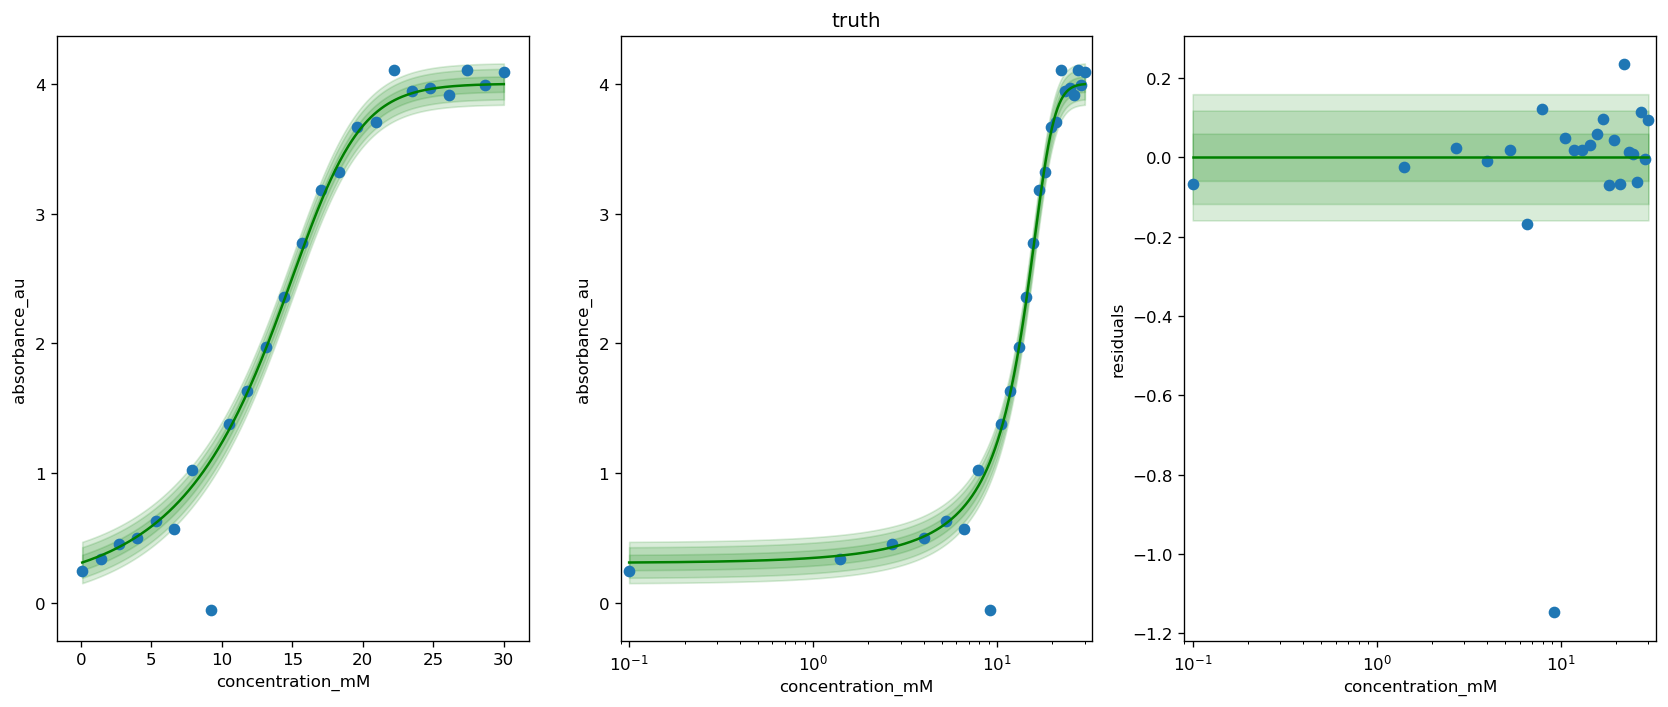

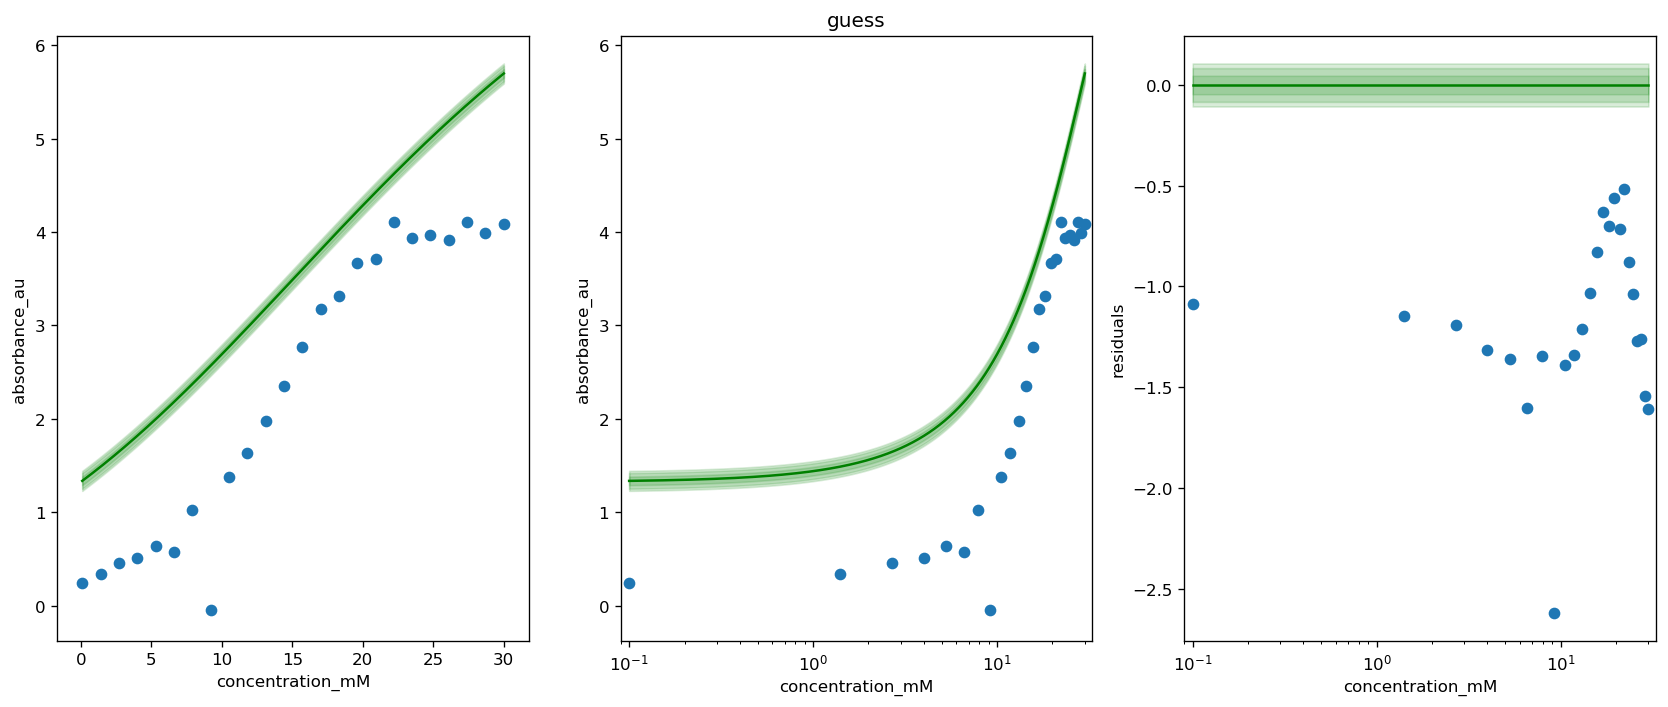

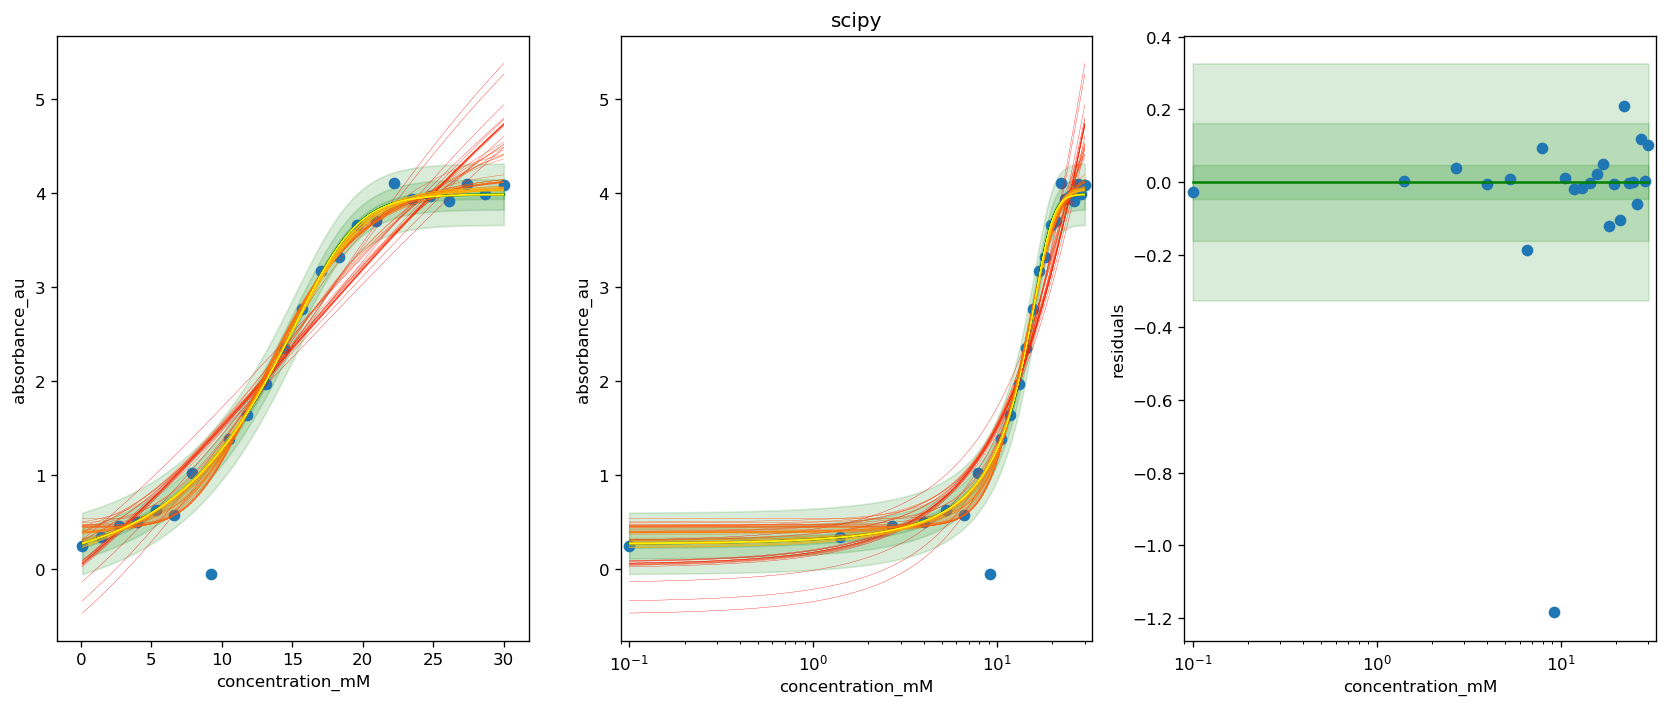

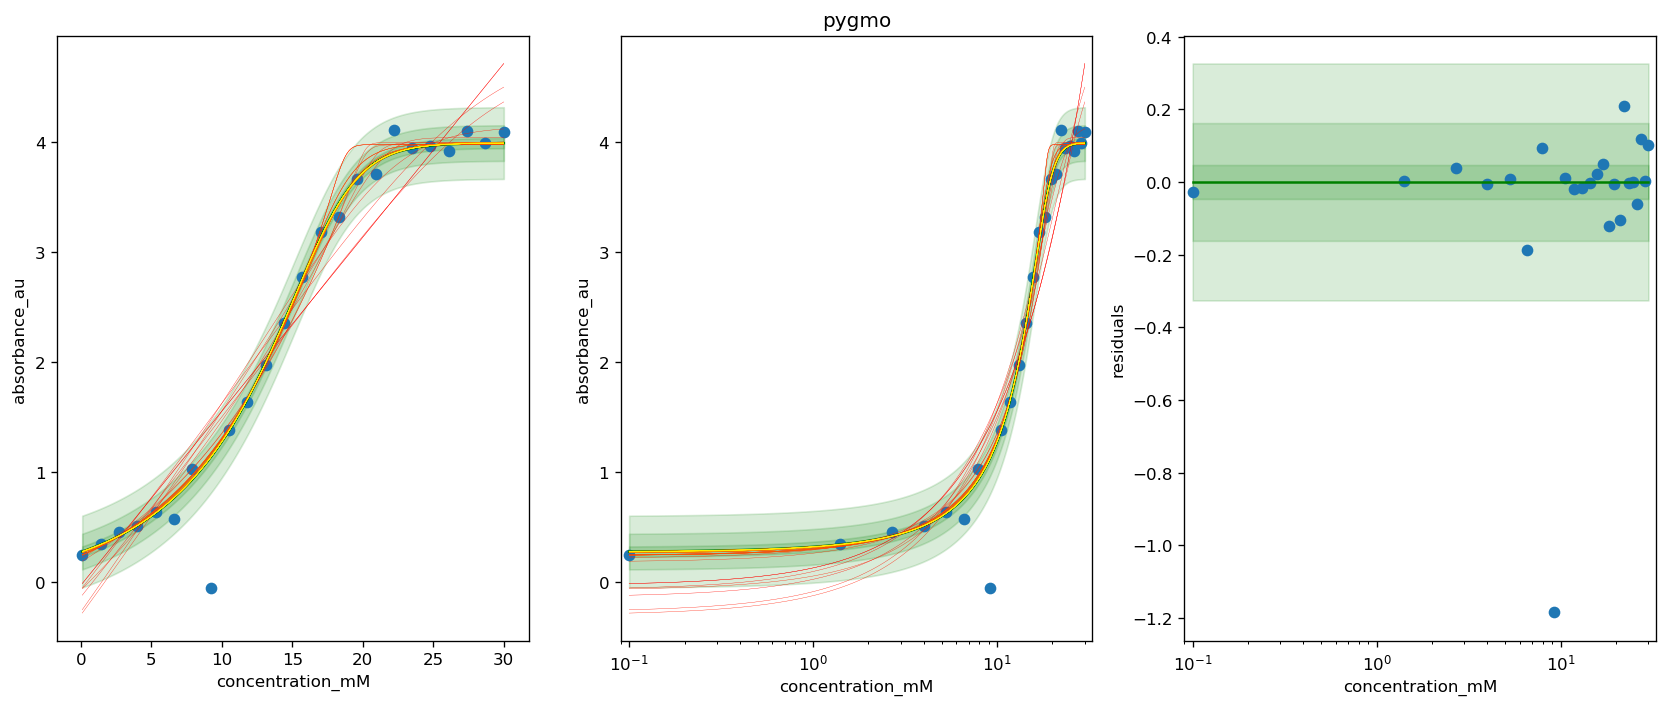

In [8]:
def plot_fit_history(axs, model, history):
    X = model.cal_independent
    for i, x in enumerate(history):
        x_dense = numpy.exp(numpy.linspace(numpy.log(min(X)), numpy.log(max(X)), 1000))
        mu, _, _ = model.predict_dependent(x_dense, theta=x)
        axs[0].plot(x_dense, mu, color=cm.autumn(i / len(history)), linewidth=0.2)
        axs[1].plot(x_dense, mu, color=cm.autumn(i / len(history)), linewidth=0.2)
    return


for method, history in zip(df_results.index, [None, None, history_scipy, history_pygmo]):
    # the plot_model method uses model.theta_fitted
    # here we override it with the parameter set found by a certain method
    model.theta_fitted = df_results.loc[method, 'θ']
    
    fig, axs = calibr8.plot_model(model)
    if history is not None:
        plot_fit_history(axs, model, history)
    axs[1].set_title(method)
    fig.tight_layout()
    pyplot.show()

In [9]:
%load_ext watermark
%watermark -n -u -v -iv -w

scipy   1.2.1
calibr8 5.0.2
pandas  1.0.5
numpy   1.16.4
last updated: Fri Dec 04 2020 

CPython 3.6.8
IPython 7.5.0
watermark 2.0.2
